[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/geometric_transforms.ipynb)

# Geometric image and points transformations

In this tutorial we will learn how to generate and manipulate geometrically  synthetic images and use their transformations to manipulate 2D points and how to combine with `torch` components to perform data augmention.

\\

<center>
<img src="https://drive.google.com/uc?id=1dK9Dc3rAJkC4uUMTCgC9oNmV_15ln33x" width="150">
</center>

> **Kornia** recently introduced a module called `kornia.augmentation` which among other functionalities, provides a set of operators to perform geometric data augmentation with the option to retrieve the applied transformation to the original image in order to perform transformations of additional data such keypoints, bound boxes, or others.
>
> Our geometric transformations API is compliant with `torchvision` including a few extras such as the flag `return_transform` that returns to the user the applied transformation to the original.
>
> Additionally, our API inherits from `nn.Module` meaning that can be combined with `nn.Sequential` and chain the different applied transformations, when this last one is used. Moreover, we can compute in batches of images using different devices such CPU/GPU (and TPU in future).
>
> Finally, all the operators are fully differentiable, a topic that we will cover in future tutorials so that users can make use of this feature.

\\

In brief, in this tutorial we will learn how to:

1. Use `kornia.augmentation.RandomAffine` to generate random views and retrieve the transformation.
2. Use `kornia.geometry.transform_points` to manipulate points between views.
3. Combine the above in a `nn.Module` with other `kornia.augmenation` components to generate a complete augmentation pipeline.

## Installation

We first install **Kornia** v0.2.0 and *Matplotlib* for visualisation.

To play with data we will use some samples from [*HPatches dataset*](https://hpatches.github.io/) [1].

> [1] *HPatches: A benchmark and evaluation of handcrafted and learned local descriptors*, Vassileios Balntas*, Karel Lenc*, Andrea Vedaldi and Krystian Mikolajczyk, CVPR 2017.

In [1]:
%%capture
!pip install kornia matplotlib 

In [2]:
%%capture
# download from: https://github.com/kornia/data
!wget https://github.com/kornia/data/raw/main/homography/img1.ppm
!wget https://github.com/kornia/data/raw/main/v_dogman.ppm
!wget https://github.com/kornia/data/raw/main/v_maskedman.ppm
!wget "https://miro.medium.com/max/6064/1*Fl89R-emhz-OLH9OZIQKUg.png" -O delorean.png

## Setup

We will import the needed libraries and create a small functionalities to make use of *OpenCV* I/O.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import kornia as K

import cv2
import numpy as np

import torch
import torch.nn as nn

Define a generic function to load images using *OpenCV* and cast to `torch.Tensor` to be use with any of the `kornia` operators.

In [4]:
def imread(data_path: str) -> torch.Tensor:
    """Utility function that load an image an convert to torch."""
    # open image using OpenCV (HxWxC)
    img: np.ndarray = cv2.imread(data_path, cv2.IMREAD_COLOR)

    # cast image to torch tensor and convert to RGB
    img_t: torch.Tensor = K.utils.image_to_tensor(img, keepdim=False)  # BxCxHxW
    img_t = K.color.bgr_to_rgb(img_t)

    return img_t.float() / 255.

Define a function for visualisation using *Matplotlib*.

In [5]:
def imshow(image: np.ndarray, height: int, width: int):
    """Utility function to plot images."""
    plt.figure(figsize=(height, width))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Since *Kornia* don't provide render functionalities, let's use OpenCV `cv2.circle` to draw points.

In [6]:
def draw_points(img_t: torch.Tensor, points: torch.Tensor) -> np.ndarray:
    """Utility function to draw a set of points in an image."""

    # cast image to numpy (HxWxC)
    img: np.ndarray = K.utils.tensor_to_image(img_t)

    # using cv2.circle() method 
    # draw a circle with blue line borders of thickness of 2 px
    img_out: np.ndarray = img.copy()

    for pt in points:
        x, y = int(pt[0]), int(pt[1])
        img_out = cv2.circle(
            img_out, (x, y), radius=10, color=(0, 0, 255), thickness=5
        )
    return np.clip(img_out, 0, 1)

## Transform single image

In this section we show how to open a single image, generate 2d random points and plot them using *OpenCV* and *Matplotlib*.

Next, we will use `kornia.augmentation.RandomAffine` to gerenate a random synthetic view of the given image and show how to retrieve the generated transformation to later be used to transform the points between images.

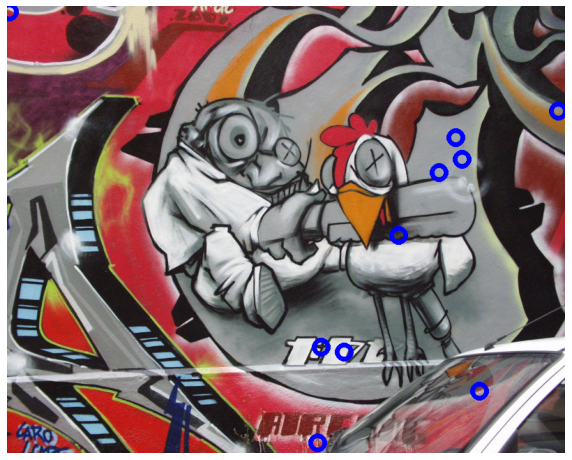

In [7]:
# load original image
img1: torch.Tensor = imread('img1.ppm')

# generate N random points within the image
N: int = 10   # the number of points
B, CH, H, W = img1.shape

points1: torch.Tensor = torch.rand(1, N, 2)
points1[..., 0] *= W
points1[..., 1] *= H

# draw points and show
img1_vis: np.ndarray = draw_points(img1[0], points1[0])

imshow(img1_vis, 10, 10)

Now lets move to a bit more complex example and start to use the `kornia.augmentation` API to transform an image and retrieve the applied transformation. We'll show how to reuse this transformation to project the 2d points between images.

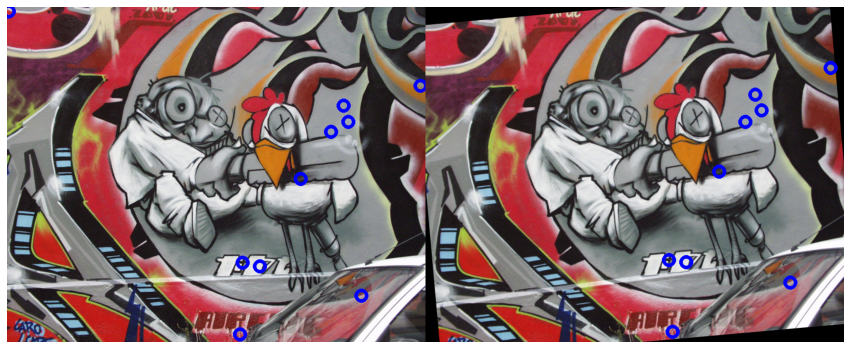

In [8]:
# declare an instance of our random affine generation eith `return_transform`
# set to True, so that we recieve a tuple with the transformed image and the
# transformation applied to the original image.
transform: nn.Module = K.augmentation.RandomAffine(
    degrees=[-45., 45.], return_transform=True, p=1.
)

# tranform image and retrieve transformation
img2, trans = transform(img1)

# transform the original points
points2: torch.Tensor = K.geometry.transform_points(trans, points1)

# visualize both images
img2_vis: np.ndarray = draw_points(img2, points2[0])

img_vis = np.concatenate([img1_vis, img2_vis], axis=1)

imshow(img_vis, 15, 15)

## Transform batch of images

In the introduction we explained about the capability of `kornia.augmentation` to be integrated with other `torch` components such as `nn.Module` and `nn.Sequential`.

We will create a small component to perform data augmentation on batched images reusing the same ideas showed before to transform images and points.

First, lets define a class that will generate samples of synthetic views with a small color augmentation using the `kornia.augmentation.ColorJitter` and `kornia.augmentation.RandomAffine` components.

NOTE: we set the forward pass to have no gradients with the decorator `@torch.no_grad()` to make it more memory efficient.

In [9]:
from typing import Dict

class DataAugmentator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # declare kornia components as class members
        self.k1 = K.augmentation.RandomAffine([-60, 60], return_transform=True, p=1.)
        self.k2 = K.augmentation.ColorJitter(0.5, 0.5, p=1.)
    
    @torch.no_grad()
    def forward(self, img1: torch.Tensor, pts1: torch.Tensor) -> Dict[str, torch.Tensor]:
        assert len(img1.shape) == 4, img1.shape

        # apply geometric transform the transform matrix
        img2, trans = self.k1(img1)

        # apply color transform
        img1, img2 = self.k2(img1), self.k2(img2)

        # finally, lets use the transform to project the points
        pts2: torch.Tensor = K.geometry.transform_points(trans, pts1)

        return dict(img1=img1, img2=img2, pts1=pts1, pts2=pts2)

Lets use the defined component and generate some syntethic data !

/usr/local/lib/python3.7/dist-packages/kornia/utils/helpers.py:96: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  out1, out2 = torch.solve(input.to(dtype), A.to(dtype))


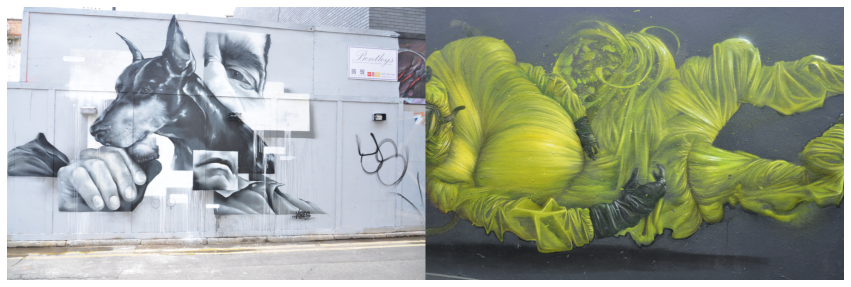

In [10]:
# load data and make a batch
img1: torch.Tensor = imread('v_dogman.ppm')
img2: torch.Tensor = imread('v_maskedman.ppm')

# crop data to make it homogeneous
crop = K.augmentation.CenterCrop((512, 786))

img1, img2 = crop(img1), crop(img2)

# visualize
img_vis = torch.cat([img1, img2], dim=-1)
imshow(K.tensor_to_image(img_vis), 15, 15)

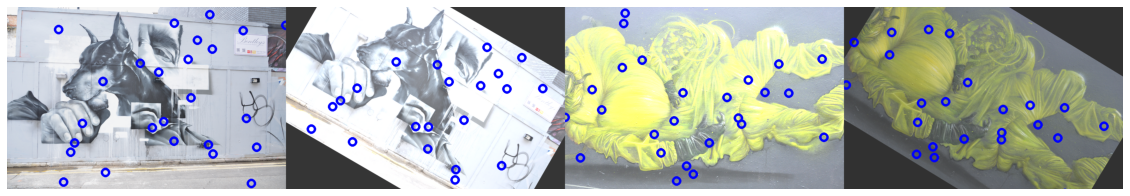

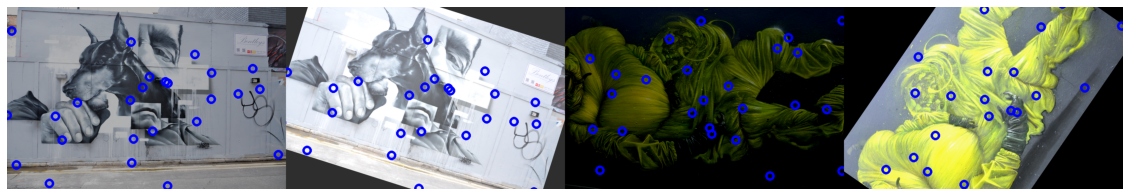

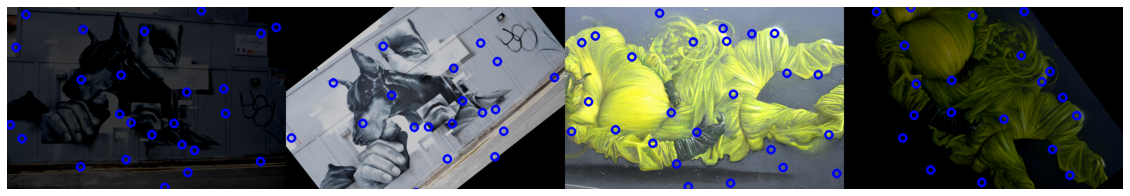

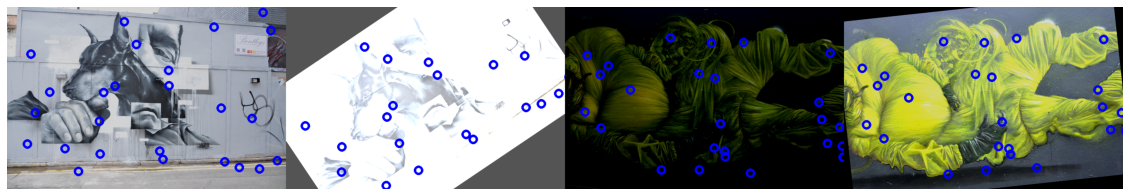

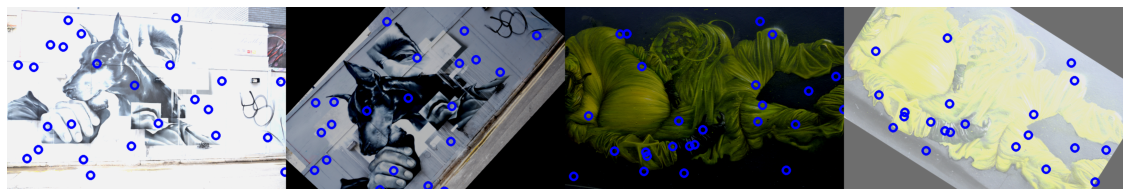

In [11]:
# create an instance of the augmentation pipeline
# NOTE: remember that this is a nn.Module and could be
# placed inside any any network, pytorch-lighting module, etc.
aug: nn.Module = DataAugmentator()

for _ in range(5):  # create some samples

    # generate batch
    img_batch = torch.cat([img1, img2], dim=0)

    # generate random points (or from a network)
    N: int = 25
    B, CH, H, W = img_batch.shape

    points: torch.Tensor = torch.rand(B, N, 2)
    points[..., 0] *= W
    points[..., 1] *= H

    # sample data
    batch_data = aug(img_batch, points)

    # plot and show
    # visualize both images

    img_vis_list = []

    for i in range(2):
        img1_vis: np.ndarray = draw_points(
            batch_data['img1'][i], batch_data['pts1'][i]
        )
        img_vis_list.append(img1_vis)

        img2_vis: np.ndarray = draw_points(
            batch_data['img2'][i], batch_data['pts2'][i]
        )
        img_vis_list.append(img2_vis)

    img_vis = np.concatenate(img_vis_list, axis=1)

    imshow(img_vis, 20, 20)

## BONUS: Backprop to the future

One of the main motivations during the desing for the `kornia.augmentation` API was to give to the user the flexibility to retrieve the applied transformation in order to achieve one of the main purposes of Kornia - *the reverse engineering*.

In this case we will show how easy one can combine **Kornia** and **PyTorch** components to *undo* the transformations and go back to the original data.

**“Wait a minute, Doc. Are you telling me you built a time machine...out of a PyTorch?”** - *Marty McFLy*

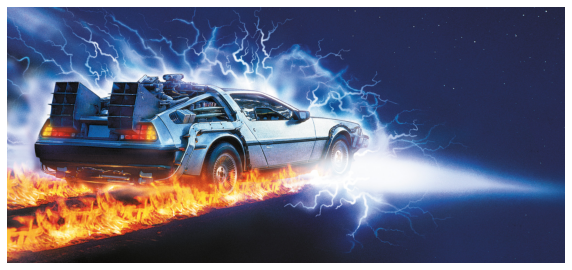

In [12]:
# lets start the Delorean engine
delorean: torch.Tensor = imread('delorean.png')

imshow(K.utils.tensor_to_image(delorean), 10, 10)

**"If my calculations are correct, when this baby hits 88 miles per hour, you're gonna see some serious shit."** - *Doc. Brown*

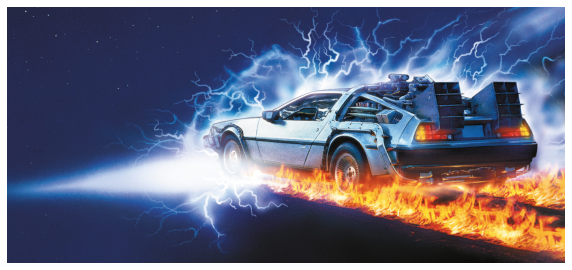

In [13]:
# turn on the time machine panel (TMP)

TMP = K.augmentation.RandomHorizontalFlip(p=1., return_transform = True)

delorean_past, time_coords_past = TMP(delorean) # go !

imshow(K.utils.tensor_to_image(delorean_past), 10, 10)

### **Let's go back to the future !**

**"Marty! You've gotta come back with me!"** - *Doc. Brown*

/usr/local/lib/python3.7/dist-packages/kornia/geometry/transform/imgwarp.py:99: UserWarning: The align_corners default value has been changed. By default now is set True in order to match cv2.warpPerspective. In case you want to keep your previous behaviour set it to False. This warning will disappear in kornia > v0.6.
  warnings.warn(message)


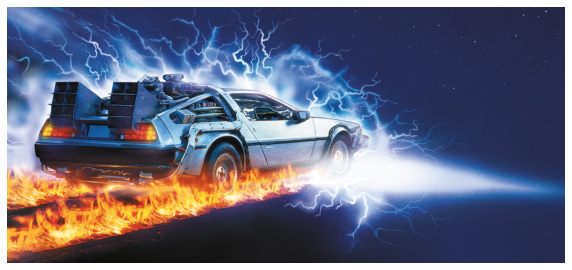

In [14]:
# lets go back to the past

time_coords_future: torch.Tensor = torch.inverse(time_coords_past)

H, W = delorean_past.shape[-2:]
delorean_future = K.geometry.warp_perspective(
    delorean_past, time_coords_future, (H, W))

imshow(K.utils.tensor_to_image(delorean_future), 10, 10)